
# Sumário
- [Nexus](#nexus)
  - [Análise Descritiva](#análise-descritiva)
  - [Ilustração Pipeline](#ilustração-pipeline)
  - [Instalações](#instalações)
  - [Importações](#importações)
  - [Carregando Arquivos](#carregando-arquivos)
  - [Pré-processamento](#pré-processamento)
      - [Segmentação](#segmentação)
      - [Tokenização](#tokenização)
      - [Stop-words](#stop-words)
      - [Lematização](#lematização)
      - [NER](#ner)
      - [Retirar Links](#retirar-links)
  - [Bag of Words (BoW)](#bag-of-words-(bow))
  - [Pipeline](#pipeline)
  - [Executar Limpeza](#executar-limpeza)
  - [Modelos](nexus.ipynb#modelos)
    - [Naive Bayes com 3 classificações](nexus.ipynb#naive-bayes-com-3-classificações)
    - [Naive Bayes com 2 classificações](nexus.ipynb#naive-bayes-com-2-classificações)
    - [Naive Bayes com Curva Gaussiana](#naive-bayes-curva-gaussiana)
  - [Métricas](#métricas)
    - [Comparação de Modelos](#comparação-das-métricas-de-desempenho-entre-modelos-gaussian-naive-bayes-e-embedding-layer)
    - [Embedding Layer](#embedding-layer)






# Nexus

## Análise Descritiva

O intuito desta análise é entender os dados apresentados para então saber quais técnicas de pré-processamento agregam mais valor no tratamento destes.

#### Instalações e Importações

In [46]:
%pip cache purge;
%pip install pandas matplotlib seaborn wordcloud collections nltk;
%pip install seaborn;
%pip install nltk;
%pip install gensim;
%pip install memory_profiler;
%pip install tensorflow

%pip install spacy;
!python -m spacy download en_core_web_sm;

Note: you may need to restart the kernel to use updated packages.


ERROR: Need an action (dir, info, list, purge, remove) to perform.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\python311\lib\site-packages (2.1.1)



ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections



Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

✘ No compatible package found for 'en_core_web_sm;' (spaCy v3.7.4)



In [47]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import unittest
import time
from memory_profiler import memory_usage

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Inteli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Início da Análise

In [48]:
# Aqui vamos fazer o upload da base de dados em nosso notebook e transformá-la em um dataframe para que possamos visuzalizá-la de uma maneira mais eficiente bem como manejá-la de modo mais fácil

df = pd.read_csv("./data/classification-labeled.csv")
pd.set_option('display.max_colwidth', None)

df.head(10)

,id,comment,sentiment
0,1,"That, my friend, is why The Mighty Swift Radio Cars of Stalybridge retain my costume.",0
1,2,"Spent 20 minutes in an Uber listening to what I can best describes as ?Eagles B-sides, but about Jesus?",0
2,3,"via The Guardian Guardian front page, Monday 11 July 2022 - The #Uber files: Leak reveals secret lobbying operation to conquer the world https://t.co/hjsUSc6AVZ",-1
3,4,My real job is being my girlfriends personal Uber/Uber eats driver Everything else is just a side gig,0
4,5,i had a bad drive . i want my refund,-1
5,6,"Uber broke laws, duped police and secretly lobbied governments, leak reveals https://t.co/JMfXJFO6jc",-1
6,7,"We're here to help. Please send us a DM with the phone number associated with your Uber account, so we can assist you further.",-1
7,8,Too many taxi drivers have told me about Uber cutting access to the app and withholding earned wages - for months at a time - due to spurious customer complaints. Driver evidence made no difference. A big data leak shows more reasons not to use them. https://t.co/DjcGHX9fYx,-1
8,9,why do uber drivers like to make conversation with me,-1
9,10,"Thing are getting serious with Uber business model,technology isn't an error but Uber do",-1


A primeira coisa que notamos é que há tweets, como o que possui id 5 ou o de id 8, formados por mais de uma frase. Assim, torna-se vantajoso segmentá-los, separando suas diferentes frases para que uma análise daquilo que expressam possa ser feita de uma maneira mais condizente com aquilo que estas objetivam expressar.

Assim, a primeira etapa a ser utilizada no pré-processamento é a <b>Segmentação</b>.

In [49]:
#Identificar se há linhas com dados nulos
contador_na = df.isna().sum(axis=1)
total_linhas_na= contador_na[contador_na > 0].count()

print("Número totalde linhas com NaN:", total_linhas_na)
#que sorte! Nenhum dado nulo.

Número totalde linhas com NaN: 0


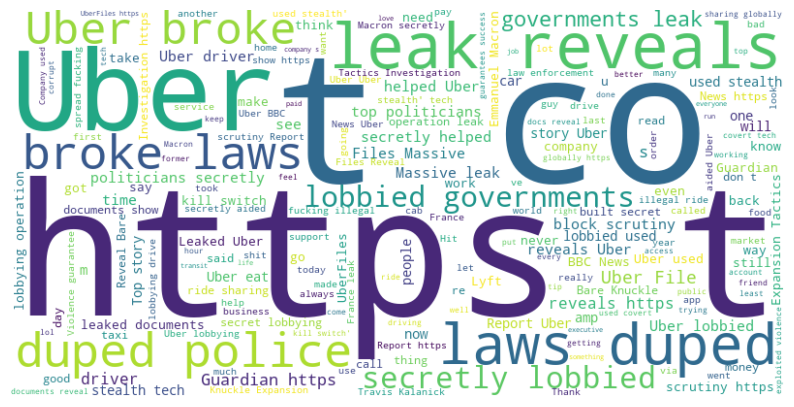

In [50]:
#Agora vamos ver as palavras que mais aparecem na base através de uma nuvem de palavras

#esta string armazenará todo o conteúdo da coluna de comentários ('comment')
todos_os_comentarios = ' '.join(df['comment'])

#gerando a nuvem de palavras
nuvem_de_palavras = WordCloud(width=800, height=400, background_color='white').generate(todos_os_comentarios)

#plotando a nuvem  usando matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(nuvem_de_palavras, interpolation='bilinear')  
plt.axis('off') 
plt.show()

Nesta nuvem podemos observar palavras como "lobbied governments", "lobbying operation", "lobbyimg drive", as quais possuem a palavra "lobby" conjugada em diversos tempos verbais. A fim de resolver problemas como essespode-se utilizar a <b>lemmatização</b>, a qual é capaz de remover as flexões das palavras, trazend, por exemplo, os verbos ao infinitivo. 

Outro fator importante é que também pode-se ver palavras como "Macron" e "Emanuel Macron" sendo apresentadas na nuvem, no entanto ambas referem-se a mesma pessoa, o presidente da França. Assim, utilizaremos <b>NER</b> (Reconhecimento de Entidades Nomeadas) para identificar tais palavras como as entidades que representam, sejam estas pessoas, lugares, etc.

Ao plotarmos as 10 primeiras linhas da nossa base, foi possível reparar 3 diferentes linhas nas quais havia urls após o tweet. Através desta nuvem de palavras, sabendo que aquelas maiores são as que mais se repetem, torna-se perceptível que o termo 'https', por exemplo, o qual inicia todas as urls, é o mais frequente nesta base. 
Tal fator mostra a necessidade de retirarmos as urls dos tweets da nossa base durante o pré-processamento.

Abaixo faremos um código para contabilizar a frequência das palavras, sendo a prova real da nossa nuvem cirada.

In [51]:
#tokenizando o texto
palavras = todos_os_comentarios.split()

#contando a frequência de cada palavra e colocando em um dicionario
dicio_frequencia_das_palavras = Counter(palavras)

#Printando os elemntos do dicionario
for palavra, frequencia in dicio_frequencia_das_palavras.items():
    print(f"{palavra}: {frequencia}")

That,: 1
my: 256
friend,: 1
is: 425
why: 36
The: 416
Mighty: 1
Swift: 1
Radio: 1
Cars: 2
of: 671
Stalybridge: 1
retain: 1
costume.: 1
Spent: 1
20: 10
minutes: 14
in: 617
an: 205
Uber: 2402
listening: 2
to: 1514
what: 76
I: 522
can: 87
best: 16
describes: 1
as: 196
?Eagles: 1
B-sides,: 1
but: 161
about: 114
Jesus?: 1
via: 63
Guardian: 242
front: 13
page,: 3
Monday: 5
11: 6
July: 6
2022: 7
-: 257
#Uber: 66
files:: 7
Leak: 24
reveals: 605
secret: 80
lobbying: 147
operation: 8
conquer: 12
the: 1507
world: 46
https://t.co/hjsUSc6AVZ: 1
My: 48
real: 12
job: 9
being: 30
girlfriends: 1
personal: 8
Uber/Uber: 1
eats: 66
driver: 139
Everything: 1
else: 4
just: 146
a: 837
side: 8
gig: 10
i: 81
had: 74
bad: 26
drive: 61
.: 34
want: 31
refund: 7
broke: 487
laws,: 500
duped: 493
police: 522
and: 1429
secretly: 643
lobbied: 463
governments,: 419
leak: 661
https://t.co/JMfXJFO6jc: 1
We're: 8
here: 28
help.: 5
Please: 16
send: 18
us: 48
DM: 10
with: 274
phone: 26
number: 19
associated: 10
your: 92
acco

Aqui já se tornou possível ver que algumas preposições, conectivos e artigos (as chamadas stop-words), as quais não trazem valor semântico às frases aparecem bastante também! 

Na nossa tentativa de entender a frequência de 'https' já tivemos um outro insight. Neste caso remover as <b>stop-words</b> (tipos de palavra supracitados) com certeza ajudará na vetorização da nossa base.

Abaixo este dicionário se tornará mais visual.

In [52]:
#vendo o comprimento do dicionário
print(f'O número de palavras diferentes na base de dados é: {len(dicio_frequencia_das_palavras)}')

O número de palavras diferentes na base de dados é: 12300


In [53]:

#descobrindo quantas stopwprds há no total no nosso texto

stop_words = set(stopwords.words('english'))

def contador_stopwords(text):
    
    ''' 
    Função para contar o número de stop-words em uma string
    
    Args: 
        text -> String na qual deseja-se identificar o número de stop-words
    Returns:
        lista com a frequência de stop-words e a frquência de outras palavras no texto.
    
    
    '''
    
    word_tokens = nltk.word_tokenize(text)
    count_stop = 0
    count_normal = 0
    for token in word_tokens:
        if token.lower() in stop_words:
            count_stop += 1
        else:
            count_normal +=1
            
    return [count_stop, count_normal]
            
print(todos_os_comentarios)
print(f'Numero total de stop-words: {contador_stopwords(todos_os_comentarios)}')

That, my friend, is why The Mighty Swift Radio Cars of Stalybridge retain my costume. Spent 20 minutes in an Uber listening to what I can best describes as ?Eagles B-sides, but about Jesus? via The Guardian  Guardian front page, Monday 11 July 2022 - The #Uber files: Leak reveals secret lobbying operation to conquer the world  https://t.co/hjsUSc6AVZ My real job is being my girlfriends personal Uber/Uber eats driver Everything else is just a side gig i had a bad drive . i want my refund Uber broke laws, duped police and secretly lobbied governments, leak reveals  https://t.co/JMfXJFO6jc We're here to help. Please send us a DM with the phone number associated with your Uber account, so we can assist you further. Too many taxi drivers have told me about Uber cutting access to the app and withholding earned wages - for months at a time - due to spurious customer complaints. Driver evidence made no difference. A big data leak shows more reasons not to use them.  https://t.co/DjcGHX9fYx why

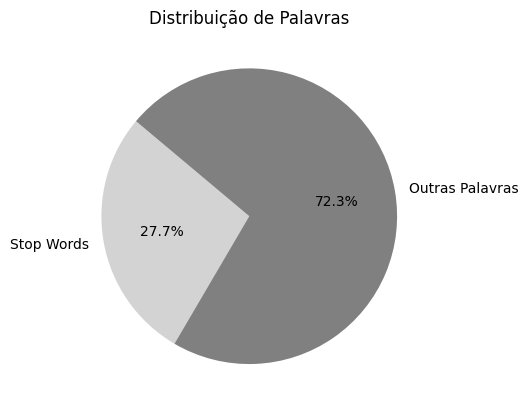

In [54]:
#plotando um gráfico de frequência das palavras
count = contador_stopwords(todos_os_comentarios)
plt.pie(count, labels = ["Stop Words", "Outras Palavras"], autopct='%1.1f%%', startangle=140, colors=["lightgrey","grey"])

plt.title("Distribuição de Palavras")

plt.show()

A partir dos resultados acima torna-se clara a necessidade de remover as stop words, pois, dado que represntam quase 30% das palavras na base de dados, sua presença pode enviesar consideravelmente os resultados do modelo utilizado no momento (Bag of Words).

No entanto, para a realização desta etapa também faz-se necessário ocorrer a <b>tokenização</b>, processo que separa o texto em tokens, ou seja, palavras, as quais podem então ser verificadas como sendo ou não stop words.

Outro ponto interessante de entender é o balanceamento da base de dados. Como os tweets estão classificados em positivo, negativo ou neutro, é bom entender o quanto de cada sentimento há para que a melhor estratégia seja descoberta e utilizada.

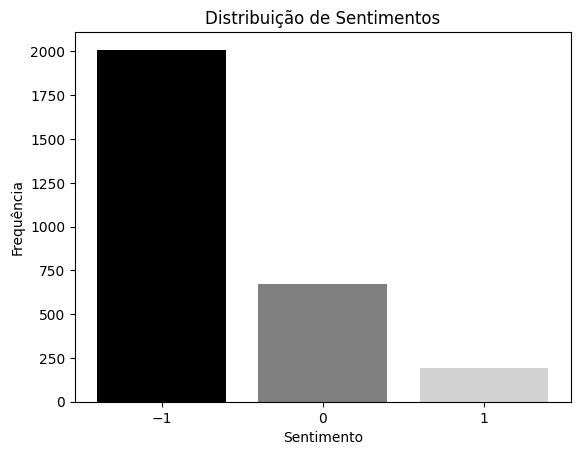

In [55]:
#Outro ponto importante é entendermos a distribuição de sentimentos nos comentários,para isso o gráfico abaixo
contagem_sentimentos = df['sentiment'].value_counts()
plt.bar(contagem_sentimentos.index, contagem_sentimentos.values, color=['black', 'grey', 'lightgrey'])

plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.title('Distribuição de Sentimentos')
plt.xticks(contagem_sentimentos.index)
plt.show()


Aqui também visualizaremos a a distribuição na base de teste chamada "test_data.csv", a qual foi criada com o auxílio de IA Generativa justamente para os testes.

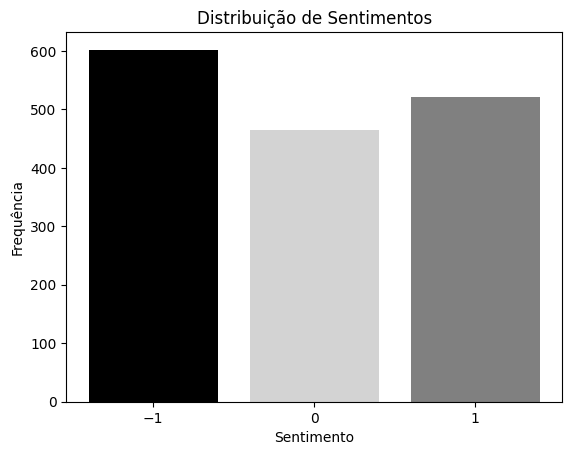

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

#carregando a base de teste
df_test = pd.read_csv("./data/test_data.csv")

#aqui plotamos um gráfico para entender a distribuição dos dados na base de dados de teste
contagem_sentimentos = df_test['sentiment'].value_counts()
plt.bar(contagem_sentimentos.index, contagem_sentimentos.values, color=['black', 'grey', 'lightgrey'])

plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.title('Distribuição de Sentimentos')
plt.xticks(contagem_sentimentos.index)
plt.show()

Acima, os sentimentos representados com '-1' são negativos, os com '0', neutros, e '1', positivos.

## Ilustração Pipeline

<div align="center">
  <sub>Figura X - Figura ilustrativa do pipeline </sub>
    <img src="../assets/Pipeline_Vertical.png" width="100%" >
  <sup>Fonte: Material produzido pelos autores (2024)</sup>
</div>

## Instalações

In [56]:

!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 660.6 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 605.3 kB/s eta 0:00:21
     --------------------------------------- 0.1/12.8 MB 605.3 kB/s eta 0:00:21
     --------------------------------------- 0.1/12.8 MB 605.3 kB/s eta 0:00:21
     --------------------------------------- 0.1/12.8 MB 387.0 kB/s eta 0:00:33
      -------------------------------------- 0.2/12.8 MB 454.0 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 538.9 kB/s eta 0:00:24
      -------------------------------------- 0.2/12.8 MB 538.9 kB/s eta 0:00:24
      -------------------------------------- 0.3/12.8 MB

In [57]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


## Importações

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

## Carregando arquivos

In [59]:
def data_load(caminho_arquivo, coluna_texto):
    """
    retorna os dados do arquivo csv, mais em especifico a coluna de texto

    Args:
        caminho_arquivo: str - O caminho para o arquivo CSV.
        coluna_texto: str - O nome da coluna no CSV que contém os textos.

    Returns:
        list: Uma lista que representa o dataframe com os textos
    """
    dados = pd.read_csv(caminho_arquivo)
    dados.dropna(subset=[coluna_texto], inplace=True)  # Remove NaN values from the specified column
    return dados[coluna_texto].to_list()

## Pré-processamento

### Segmentação

In [60]:
def segmentacao(texto, nlp):
    """
    Segmenta um texto em frases usando um modelo de processamento de linguagem.

    Args:
        texto: str - O texto a ser segmentado em frases.

    Returns:
        list: Uma lista das frases segmentadas.
    """


    # Processa o texto usando o modelo SpaCy
    doc = nlp(texto)

    # Extrai cada frase do documento e armazena na lista
    frases_segmentadas = [sent.text for sent in doc.sents]
    
    # Retorna a lista de frases segmentadas
    return frases_segmentadas


### Tokenização

In [61]:
def tokenizar(texto, nlp):
    """
    Tokeniza um texto em palavras usando um modelo de processamento de linguagem.

    Args:
        texto: str - O texto a ser tokenizado em palavras.
        nlp: Modelo de processamento de linguagem.
    Returns:
        list: Uma lista de palavras tokenizadas.
    """
    # Processa o texto usando o modelo SpaCy

    doc = nlp(texto)
    # Extrai os tokens do documento e retorna como lista de textos de tokens em minúsculas
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    return tokens

### Stop-Words

In [62]:
#funçao de stop words
def remove_stop_words(tokens, nlp):
    """
    Remove as stop words de uma lista de tokens.

    Args:
        tokens: list - Uma lista de tokens.

    Returns:
        list: Uma lista de tokens sem as stop words.
    """
    # Carrega as stop words do modelo SpaCy
    stop_words = nlp.Defaults.stop_words

    # Remove as stop words dos tokens
    return [token for token in tokens if token not in stop_words]

### Lematização

In [63]:
def lematizacao(tokens, nlp):
    """
    Transforma cada palavra para sua base usando um lematizador.

    Args:
        tokens: list - Uma lista de palavras a serem lematizadas.
        nlp: Language - Modelo SpaCy carregado para processamento de linguagem.

    Returns:
        list: Uma lista das palavras lematizadas.
    """

    # Processa a string obtida pela junção dos elementos da lista
    doc = nlp(' '.join(tokens))

    # Extrai o lema de cada token no documento e armazena na nova lista
    frase_lematizada = [token.lemma_ for token in doc]
    
    # Retorna a lista lematizada
    return frase_lematizada

### NER

In [64]:
def NER(texto, nlp):
    """
    Categoriza as palavras como entidades e tipos.

    Args:
        texto: str - O texto a ser processado.

    Returns:
        
    """

    doc = nlp(texto)
    
    print([(ent.text, ent.label_) for ent in doc.ents])

    return [(ent.text, ent.label_) for ent in doc.ents]


### Retirar links

In [66]:
#se a palavra começar com https ou http ela deve ser removida

def remove_http(texto):
    '''
    Função que remove palavras que começam com http ou https
    
    Args:
        texto : str -> texto que será processado
    
    Returns:
        texto : str -> texto sem as palavras que começam com http ou https
    '''
    
    # Expressão regular para identificar palavras que começam com http ou https
    padrao = r'\b(?:https?://\S+)\b'
    
    # Substitui as palavras que correspondem ao padrão por uma string vazia
    texto_sem_http = re.sub(padrao, '', texto)
    
    return texto_sem_http

## Bag of Words (Bow)

Abaixo seguem-se tópicos com algumas características deste modelo:
- É um método de vetorização de texto;
- Mede a frequência das palavras, de determinado vocabulário, nas frases;
- Não é capaz de identificar similaridade semântica, podendo tornar-se impreciso ao considerar apenas a similaridade léxica



In [71]:
def bag_of_words(path):

  '''
  Função que aplica o modelo bag of words, transforma as frases em vetores que são as linhas de uma matriz
  
  Args:
    None
  
  Returns:
    DataFrame : dataframe -> dataframe com as palavras e a frequência de cada uma nas frases
  '''
  
  #ler df cleaned_data
  df = pd.read_csv(path)
  
  #montar o bow considerando que cada linha é uma frase e que as palavras são as colunas
  vectorizer = CountVectorizer()
  bow = vectorizer.fit_transform(df["0"])
  bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())
  
  return bow_df

## Pipeline

In [67]:
def pipeline(nlp, texto):
    """
    Executa um pipeline de processamento de texto.

    Args:
        nlp: Language - Modelo SpaCy carregado para processamento de linguagem.
        texto: str - O texto a ser processado.

    Returns:
        list: Uma lista de frases segmentadas.
        list: Uma lista de tokens.
        list: Uma lista de tokens sem stop words.
        list: Uma lista de tokens lematizados.
        list: Uma lista de tuplas com as entidades e tipos.
    """

    # Segmenta o texto em frases
    frases = segmentacao(texto, nlp)

    #remove os links
    newTexto = remove_http(texto)

    # Tokeniza o texto
    tokens = tokenizar(newTexto, nlp)

    # Remove as stop words
    tokens_sem_stop_words = remove_stop_words(tokens, nlp)
    
    tokens_lematizados = lematizacao(tokens_sem_stop_words, nlp)

    # Identifica as entidades nomeadas
    entidades_nomeadas = NER(texto, nlp)

    return " ".join(tokens_lematizados)



## Executar limpeza

In [68]:
def clean_data():
    """
    Carrega os dados do arquivo CSV e executa um pipeline de processamento de texto.
        Args:
            None
        Returns:
            list: Uma lista de textos processados.
    """
    data = data_load("./data/classification-labeled.csv", "comment")
    nlp = spacy.load("en_core_web_sm")
    cleaned_data = []
    for texto in data:
        cleaned_data.append(pipeline(nlp, texto))
    #salva os dados limpos em um arquivo csv
    df = pd.DataFrame(cleaned_data)
    df.to_csv('./data/cleaned_data.csv', index=False)
    return cleaned_data


In [69]:
cleaned = clean_data()


[('The Mighty Swift Radio Cars of', 'ORG'), ('Stalybridge', 'NORP')]
[('20 minutes', 'TIME'), ('Jesus', 'PERSON')]
[('Guardian', 'ORG'), ('Monday 11', 'DATE'), ('July 2022', 'DATE')]
[('Uber/Uber', 'ORG')]
[]
[]
[('DM', 'GPE')]
[('months', 'DATE'), ('https://t.co/DjcGHX9fYx', 'ORG')]
[]
[]
[('didn?t', 'ORG'), ('100s', 'CARDINAL'), ('millions', 'CARDINAL'), ('VC', 'GPE')]
[('https://t.co/9DxclvnZ5Z', 'GPE')]
[('2013 to 2017', 'DATE'), ('Uber', 'PERSON'), ('https://t.co/w0xsiLYL8D', 'PERSON')]
[]
[]
[('BBC News', 'ORG'), ('Uber BBC News', 'ORG'), ('Uber  https://t.co/ISRfSUc5n9', 'PERSON')]
[('Macron Uber Alles', 'PERSON')]
[('https://t.co/R5txdagJJC', 'DATE')]
[('Belgium', 'GPE'), ('10 2022', 'DATE'), ('1', 'CARDINAL'), ('FRAITA', 'ORG'), ('14', 'CARDINAL'), ('319.7', 'CARDINAL'), ('4', 'CARDINAL'), ('LoveIsland', 'ORG'), ('186.1', 'CARDINAL'), ('Sri Lanka', 'PERSON'), ('159.1', 'CARDINAL'), ('Sainz', 'ORG'), ('71.3', 'CARDINAL'), ('Belgium', 'GPE')]
[('Uber', 'PERSON')]
[('bro', 'ORG')

In [72]:
#Aplicando bag of words
bow = bag_of_words("./data/cleaned_data.csv")

#juntar lateralmente os dataframes
df_classificacao = pd.read_csv('./data/classification-labeled.csv')
df_bow = pd.concat([df_classificacao, bow], axis=1)

## Modelos

### Naive Bayes com 3 classificações 

&emsp;&emsp;O _Naive Bayes_ é um algoritmo de classificação probabilística baseado no Teorema de Bayes. Em essência, ele analisa um conjunto de dados em busca de características comuns. Com base nesses padrões, o modelo calcula as probabilidades de cada recurso (característica) para cada classe apresentada. Após a fase de treinamento, o modelo pode classificar novas entradas com base nesses cálculos probabilísticos.

&emsp;&emsp;Abaixo, foram conduzidos testes com o algoritmo mencionado para compreender seu desempenho em soluções de Modelos de Processamento de Linguagem Natural (NLP). Os resultados a seguir foram obtidos em diversas situações, cada uma delas será explicada detalhadamente:

&emsp;&emsp;Primeiramente, foi aplicado o modelo _Naive Bayes_ sem nenhuma outra técnica. Isso para que fosse possível entender o seu comportamento no conjunto de dados apresentados após a limpeza dos dados.

In [73]:
def evaluate_naive_bayes(df_bow):
    """
    Avalia um modelo Naive Bayes usando o dataframe fornecido.

    Parâmetros:
    df_bow (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.

    Retorna:
    None: A função imprime as métricas de avaliação do modelo Naive Bayes para treino e teste.
    """
    X = df_bow.drop(columns=["id", "sentiment", "comment"])
    Y = df_bow.iloc[:, 2]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Treinamento do modelo Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    # Previsões no conjunto de teste
    predictions = nb_model.predict(X_test)

    # Avaliação do modelo de teste
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'Matriz de confusão do teste:\n{conf_matrix}')

    # f1_score
    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    # precision
    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    # recall
    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    print("\n")

    print('Treino')

    # Avaliação do modelo de treino
    predictions_train = nb_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    print(f'Acurácia: {accuracy_train}')

    # Matriz de confusão
    conf_matrix_train = confusion_matrix(y_train, predictions_train)
    print(f'Matriz de confusão do modelo de treino:\n{conf_matrix_train}')

    # f1_score
    f1_train = f1_score(y_train, predictions_train, average='macro')
    print(f'f1_score: {f1_train}')

    # precision
    precision_train = precision_score(y_train, predictions_train, average='macro')
    print(f'precision: {precision_train}')

    # recall
    recall_train = recall_score(y_train, predictions_train, average='macro')
    print(f'recall: {recall_train}')
    
evaluate_naive_bayes(df_bow)


Acurácia do teste: 0.6917728852838934
Matriz de confusão do teste:
[[482 126  10]
 [ 66 111  12]
 [ 12  40   4]]
f1_score: 0.4640973294610931
precision: 0.47176082040702977
recall: 0.4795551446036883


Treino
Acurácia: 0.854942871336314
Matriz de confusão do modelo de treino:
[[1264  123    5]
 [  88  394    0]
 [  31   45   63]]
f1_score: 0.7581586383985185
precision: 0.8471644579380401
recall: 0.7262369243251842


### Aplicando oversampling 

&emsp;&emsp;Após a aplicação padrão do modelo, levando em consideração o desbalanceamento presente entre as classes no conjunto de dados fornecido, foi realizada uma técnica de oversampling. Para isso, utilizamos a biblioteca _SMOTE_, que gera dados sintéticos e os adiciona às classes com menor representação no conjunto de dados. Essa abordagem visa equilibrar a distribuição das classes, melhorando assim o desempenho do modelo em lidar com o desbalanceamento.

In [74]:

def evaluate_naive_bayes_with_smote(df_bow):
    """
    Avalia um modelo Naive Bayes com SMOTE usando o dataframe fornecido.

    Args:
    df_bow (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.

    Returns:
    None: A função imprime as métricas de avaliação do modelo Naive Bayes com SMOTE para treino e teste.
    """
    X = df_bow.drop(columns=["id", "sentiment", "comment"])
    Y = df_bow.iloc[:, 2]

    smote = SMOTE()
    X_smote, Y_smote = smote.fit_resample(X, Y)

    X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size=0.3, random_state=42)

    # Treinamento do modelo Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    # Previsões no conjunto de teste
    predictions = nb_model.predict(X_test)

    # Avaliação do modelo de teste
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'Matriz de confusão do teste:\n{conf_matrix}')

    # f1_score
    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    # precision
    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    # recall
    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    print("\n")

    print('Treino')

    # Avaliação do modelo de treino
    predictions_train = nb_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    print(f'Acurácia: {accuracy_train}')

    # Matriz de confusão
    conf_matrix_train = confusion_matrix(y_train, predictions_train)
    print(f'Matriz de confusão do modelo de treino:\n{conf_matrix_train}')

    # f1_score
    f1_train = f1_score(y_train, predictions_train, average='macro')
    print(f'f1_score: {f1_train}')

    # precision
    precision_train = precision_score(y_train, predictions_train, average='macro')
    print(f'precision: {precision_train}')

    # recall
    recall_train = recall_score(y_train, predictions_train, average='macro')
    print(f'recall: {recall_train}')
    
evaluate_naive_bayes_with_smote(df_bow)


Acurácia do teste: 0.6605859590934218
Matriz de confusão do teste:
[[460 103  42]
 [ 46 188 373]
 [ 10  40 547]]
f1_score: 0.6410935217298648
precision: 0.6760185892132776
recall: 0.6620994729373978


Treino
Acurácia: 0.726605069888652
Matriz de confusão do modelo de treino:
[[1158  166   81]
 [  45  534  824]
 [  22   16 1375]]
f1_score: 0.7097572451748557
precision: 0.7647287845844993
recall: 0.7259730417617537


### Naive Bayes com 2 classificações

&emsp;&emsp;Outro método que pode ser empregado para otimizar a eficácia do modelo é a conversão de classes. Dado que o modelo é de classificação binária, ele funciona melhor quando há apenas duas classes. Portanto, uma abordagem adotada foi converter os sentimentos neutros para positivos. Isso significa que na coluna '_sentiment_', onde o valor era igual a 0, ele foi substituído por 1. Essa conversão foi realizada com dois objetivos: aumentar a eficácia do modelo e equilibrar as classes. Primeiramente, isso será feito sem o _oversampling_.

In [75]:

def evaluate_naive_bayes_2_classes(df_bow):
    """
    Avalia um modelo Naive Bayes com 2 classes usando o dataframe fornecido.
    
    Args:
        df_bow (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo Naive Bayes com 2 classes para treino e teste.
    """
    #criar copia do dataframe
    new_df_bow = df_bow.copy()
    new_df_bow["sentiment"] = df_bow["sentiment"].replace(0,1)

    evaluate_naive_bayes(new_df_bow)
    
evaluate_naive_bayes_2_classes(df_bow)


Acurácia do teste: 0.7555040556199305
Matriz de confusão do teste:
[[469 149]
 [ 62 183]]
f1_score: 0.7253387392850086
precision: 0.7172219953259364
recall: 0.7529192259428044


Treino
Acurácia: 0.8797814207650273
Matriz de confusão do modelo de treino:
[[1222  170]
 [  72  549]]
f1_score: 0.8646530934308354
precision: 0.8539595393739803
recall: 0.8809657671164418


&emsp;&emsp; Contudo, como é possível ver na matriz de confusão da proposta de modelo acima, os dados ainda estão desbalanceados. Com isso, é possível aplicar novamente o oversamplig para que seja possível entender se há uma melhora significativa nas métricas do modelo. 

In [76]:
def evaluate_naive_bayes_with_smote_2_classes_oversampling(df_bow):
    """
    Avalia um modelo Naive Bayes com SMOTE e 2 classes usando o dataframe fornecido.
    
    Args:
        df_bow (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo Naive Bayes com SMOTE e 2 classes para treino e teste.
    """
    new_df_bow = df_bow.copy()
    new_df_bow["sentiment"] = df_bow["sentiment"].replace(0,1)
    
    evaluate_naive_bayes_with_smote(new_df_bow)
    
evaluate_naive_bayes_with_smote_2_classes_oversampling(df_bow)

Acurácia do teste: 0.8126036484245439
Matriz de confusão do teste:
[[429 178]
 [ 48 551]]
f1_score: 0.8106660961187925
precision: 0.8276004865802211
recall: 0.8133104872756076


Treino
Acurácia: 0.892679459843639
Matriz de confusão do modelo de treino:
[[1158  245]
 [  57 1354]]
f1_score: 0.8921562705420434
precision: 0.899932828388113
recall: 0.8924886582513021


&emsp;&emsp; Após essa análise primária dos dados aplciados a um modelo de classificação, é possível ver que mesmo com modelos mais simples, como o de _Naive Bayes_, há a possibilidade de alcançar resultados satisfatórios. Isso pois, com o modelo sem nenhuma técnica de balanceamento, foi possivel chegar às seguintes métricas:

 - f1 score: 0.4640973294610931
 - precision: 0.47176082040702977
 - recall: 0.4795551446036883

&emsp;&emsp; No entanto, mesmo com essas métricas, o modelo ainda apresentava um alto índice de erro, especialmente na classificação dos comentários com sentimento negativo (a classe com o maior conjunto de dados). Além disso, havia indícios de possível overfitting, possivelmente devido ao desbalanceamento significativo entre os exemplos de cada classe. As métricas obtidas nos dados de treino foram as seguintes

 - f1 score: 0.7581586383985185
 - precision: 0.8471644579380401
 - recall: 0.7262369243251842

&emsp;&emsp; No entanto, ainda foi possível aplicar oversampling para melhorar o balanceamento das classes. Com isso, observou-se uma melhora significativa nas métricas apresentadas. No entanto, é importante destacar que essa melhoria pode ser resultado de um possível _overfitting_ criado pela adição de dados com o _SMOTE_.

&emsp;&emsp; Por fim, foi aplicada uma conversão de classes. Nessa, dados de sentimentos neutros(valor na coluna _sentiment_ igual a 0) foram convertidos para sentimentos positivos(valor igual a 1). Com isso, foi possível melhorar o balanceamento dos dados, mas ainda era possível enxergar que havia mais que o dobro de sentimentos negativos se comparado com a nova classe de sentimentos positivos + neutros. Com isso, foi novamente aplicado um método de _oversampling_.

&emsp;&emsp; Contudo, modelos como _Naive Bayes_ não são, atualmente, os melhores para trabalhar com PLN, então, futuramente, serão aplicados novos modelos para comparação.

### Word2Vec Model

Importando o modelo de 300 dimensões do google

In [77]:
from gensim.models import KeyedVectors

model_path = './data/GoogleNews-vectors-negative300.bin'

model = KeyedVectors.load_word2vec_format(model_path, binary=True)


Abaixo será realizado um teste do vetor da palavra "word"

In [78]:
vector = model['word']
print(vector)

[ 3.59375000e-01  4.15039062e-02  9.03320312e-02  5.46875000e-02
 -1.47460938e-01  4.76074219e-02 -8.49609375e-02 -2.04101562e-01
  3.10546875e-01 -1.05590820e-02 -6.15234375e-02 -1.55273438e-01
 -1.52343750e-01  8.54492188e-02 -2.70996094e-02  3.84765625e-01
  4.78515625e-02  2.58789062e-02  4.49218750e-02 -2.79296875e-01
  9.09423828e-03  4.08203125e-01  2.40234375e-01 -3.06640625e-01
 -1.80664062e-01  4.73632812e-02 -2.63671875e-01  9.08203125e-02
  1.37695312e-01 -7.20977783e-04  2.67333984e-02  1.92382812e-01
 -2.29492188e-02  9.70458984e-03 -7.37304688e-02  4.29687500e-01
 -7.93457031e-03  1.06445312e-01  2.80761719e-02 -2.29492188e-01
 -1.91650391e-02 -2.36816406e-02  3.51562500e-02  1.71875000e-01
 -1.12304688e-01  6.25000000e-02 -1.69921875e-01  1.29882812e-01
 -1.54296875e-01  1.58203125e-01 -7.76367188e-02  1.78710938e-01
 -1.72851562e-01  9.96093750e-02  3.94531250e-01  6.44531250e-02
 -6.83593750e-02 -3.18359375e-01  5.95703125e-02 -1.02539062e-02
  9.37500000e-02  8.25195

Agora a função abaixo irá calcular o vetor de uma frase a partir das diversas palavras de uma frase.

In [79]:
def get_average_word2vec(tokens_list, model, generate_missing=False, k=300):
    """
    Obtém o vetor médio de um texto usando um modelo Word2Vec.
    
    Args:
        tokens_list (list): Lista de tokens.
        model (KeyedVectors): Modelo Word2Vec treinado.
        generate_missing (bool): Se True, gera vetores para palavras ausentes no modelo.
        k (int): Dimensão do vetor.
    
    Returns:
        np.array: Vetor médio do texto.
    """
    if len(tokens_list) < 1:
        return np.zeros(k)
    vectorized = [model[word] if word in model else np.zeros(k) for word in tokens_list]
    avg_vec = np.mean(vectorized, axis=0)
    return avg_vec

Vetoriza o texto usando o modelo fornecido

In [80]:
def vectorize_text(df, model):
    """
    Vetoriza um texto usando um modelo Word2Vec.
    
    Args:
        df (DataFrame): DataFrame contendo os textos.
        model (KeyedVectors): Modelo Word2Vec treinado.
        
    Returns:
        np.array: Vetores dos textos.
    """
    vectorized_texts = []
    for text in df:
        tokens = text.split()
        vectorized_texts.append(get_average_word2vec(tokens, model))
    return np.array(vectorized_texts)

agora uma função auxiliar, apenas para plotar as matrizes de confusão

In [81]:
def plot_confusion_matrix(cm, labels):
    """
    Plota uma matriz de confusão.
    
    Args:
        cm (np.array): Matriz de confusão.
        labels (list): Lista de rótulos.
    
    Returns:
        None: A função plota a matriz de confusão.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### Naive Bayes Curva Gaussiana

In [82]:
def evaluate_naive_bayes_word2vec(model, df):
    """
    Avalia um modelo Naive Bayes com Word2Vec usando o dataframe fornecido.
    
    Args:
        model (KeyedVectors): Modelo Word2Vec treinado.
        df (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo Naive Bayes com Word2Vec para treino e teste.
    """
    X = df['comment']
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vetorizando os textos
    X_train_vectors = vectorize_text(X_train, model)
    X_test_vectors = vectorize_text(X_test, model)

    # Treinamento do modelo Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train_vectors, y_train)

    # Previsões no conjunto de teste
    predictions = nb_model.predict(X_test_vectors)

    # Avaliação do modelo de teste
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    conf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(conf_matrix, labels=['Negatives', 'Positive-Neutrals'])  


Testando Naive Bayes

Acurácia do teste: 0.7497103128621089
f1_score: 0.7200273952851273
precision: 0.712577991898997
recall: 0.7488739184994386


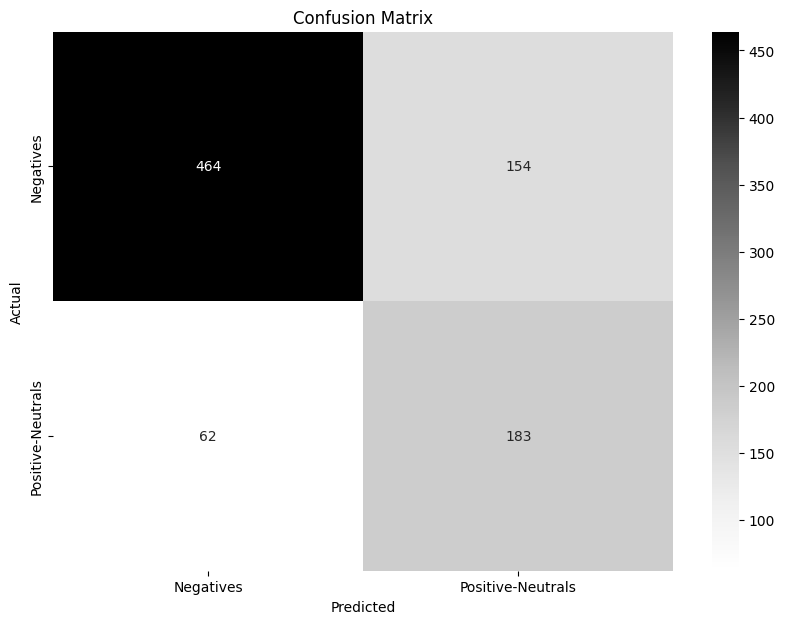

In [83]:
# Carregamento dos dados
dataframe_classification = pd.read_csv('./data/classification-labeled.csv').dropna(axis=0).replace(0,1).replace(-1,0)
dataframe_cleaned = pd.read_csv('./data/cleaned_data.csv')
df_word2vec = pd.concat([dataframe_classification, dataframe_cleaned], axis=1)

evaluate_naive_bayes_word2vec(model, df_word2vec)

### Testes para Função de Naive Bayes

Esta célula contém testes unitários para a função `evaluate_naive_bayes`, que simula a avaliação de um modelo de classificação Naive Bayes. A classe `TestNaiveBayes` verifica dois cenários: o primeiro onde a função é testada com entradas válidas usando um `MockModel` para garantir que as predições sejam processadas corretamente, e o segundo teste verifica a robustez da função ao lidar com entradas inválidas, esperando um tratamento de erro apropriado.


In [84]:
class MockModel:
    def predict(self, data):
        return ['positive' for _ in data]

def evaluate_naive_bayes_word2vec(model=None, df=None):
    try:
        if model is None or df is None:
            raise ValueError("Model and DataFrame must not be None")
        return model.predict(df['comment'])
    except Exception as e:
        return f"Error: {str(e)}"

class TestNaiveBayesEvaluation(unittest.TestCase):
    def test_evaluate_naive_bayes_word2vec(self):
        """
        Testa se a função pode ser chamada sem gerar erros,
        verificando a presença da coluna 'comment' necessária para o processamento.
        """
        # Criando DataFrame com a coluna correta
        data = {'comment': ["I enjoy coding", "I hate debugging", "This is average"]}
        df = pd.DataFrame(data)

        # Instanciando o modelo mock
        model = MockModel()

        # Executando o teste
        result = evaluate_naive_bayes_word2vec(model, df)
        expected_result = ['positive', 'positive', 'positive']

        # Verificando se o resultado é como esperado
        self.assertEqual(result, expected_result, "The function did not return the expected results.")
        print("Test passed successfully with expected results.")

    def test_naive_bayes_with_invalid_input(self):
        """
        Testa a função com entrada inválida (coluna ausente) para garantir que ela lide corretamente com erros.
        """
        # Criando DataFrame sem a coluna necessária
        data = {'wrong_column': ["I enjoy coding", "I hate debugging", "This is average"]}
        df = pd.DataFrame(data)

        # Instanciando o modelo mock
        model = MockModel()

        # Executando o teste
        result = evaluate_naive_bayes_word2vec(model, df)
        
        # Verificando se a função lida corretamente com a entrada inválida
        self.assertIn("Error", result, "Function should handle missing 'comment' column correctly.")
        print("Test passed successfully with error handling.")

# Executando os testes
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


Test passed successfully with expected results.
Test passed successfully with error handling.


### Random Forest

In [85]:
def evaluate_random_forest_word2vec(df, model):
    """
    Avalia um modelo Random Forest com Word2Vec usando o dataframe fornecido.
    
    Args:
        model (KeyedVectors): Modelo Word2Vec treinado.
        df (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo Random Forest com Word2Vec para treino e teste.
    """
    X = df['comment']
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vetorizando os textos
    X_train_vectors = vectorize_text(X_train, model)
    X_test_vectors = vectorize_text(X_test, model)

    # Treinamento do modelo Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_vectors, y_train)

    # Previsões no conjunto de teste
    predictions = rf_model.predict(X_test_vectors)

    # Avaliação do modelo de teste
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    conf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(conf_matrix, labels=['Negatives', 'Positive-Neutrals'])

Acurácia do teste: 0.7775202780996524
f1_score: 0.7296965742251222
precision: 0.7271252579979359
recall: 0.7325705039297272


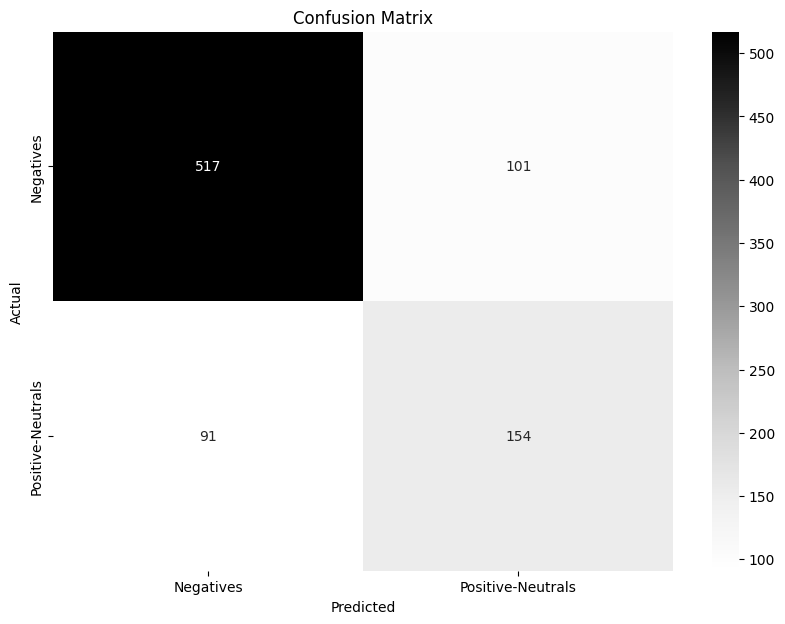

In [86]:
evaluate_random_forest_word2vec(df_word2vec, model)

### Regressão logistica

In [87]:
import pickle as pkl

def logistic_regression_word2vec(df, model):
    """
    Avalia um modelo de regressão logística com Word2Vec usando o dataframe fornecido.
    
    Args:
        model (KeyedVectors): Modelo Word2Vec treinado.
        df (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo de regressão logística com Word2Vec para treino e teste.
    """
    
    print(df.head()) 
    df["0"] = df["0"].astype(str)
    X = df['0']
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vetorizando os textos
    X_train_vectors = vectorize_text(X_train, model)
    X_test_vectors = vectorize_text(X_test, model)

    # Treinamento do modelo de regressão logística
    lr_model = LogisticRegression()
    lr_model.fit(X_train_vectors, y_train)

    # Previsões no conjunto de teste
    predictions = lr_model.predict(X_test_vectors)

    # Avaliação do modelo de teste
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    conf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(conf_matrix, labels=['Negatives', 'Positive-Neutrals'])
    
    # fazer metricas de treino
    predictions_train = lr_model.predict(X_train_vectors)
    accuracy_train = accuracy_score(y_train, predictions_train)
    print(f'Acurácia do treino: {accuracy_train}')
    
    f1_train = f1_score(y_train, predictions_train, average='macro')
    print(f'f1_score do treino: {f1_train}')

    precision_train = precision_score(y_train, predictions_train, average='macro')
    print(f'precision do treino: {precision_train}')
    
    recall_train = recall_score(y_train, predictions_train, average='macro')
    print(f'recall do treino: {recall_train}')
    
    # salvar o modelo
    pkl.dump(lr_model, open('./model/logistic_regression_model.pkl', 'wb'))
    
    


   id  \
0   1   
1   2   
2   3   
3   4   
4   5   

                                                                                                                                                              comment  \
0                                                                               That, my friend, is why The Mighty Swift Radio Cars of Stalybridge retain my costume.   
1                                                             Spent 20 minutes in an Uber listening to what I can best describes as ?Eagles B-sides, but about Jesus?   
2  via The Guardian  Guardian front page, Monday 11 July 2022 - The #Uber files: Leak reveals secret lobbying operation to conquer the world  https://t.co/hjsUSc6AVZ   
3                                                               My real job is being my girlfriends personal Uber/Uber eats driver Everything else is just a side gig   
4                                                                                                   

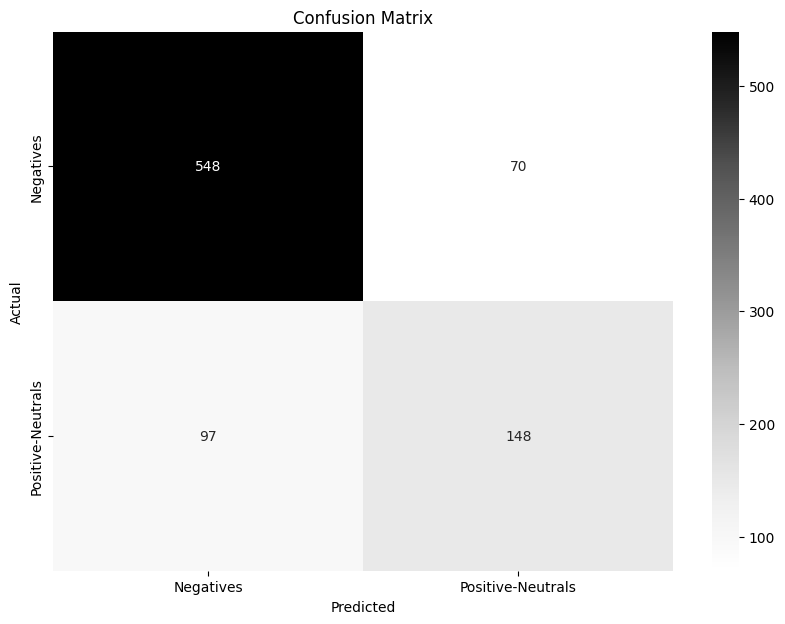

Acurácia do treino: 0.8504719324391455
f1_score do treino: 0.8246873358920312
precision do treino: 0.82483268878957
recall do treino: 0.8245425898162031


In [88]:
logistic_regression_word2vec(df_word2vec, model)

A seguir existem 2 células de código. Elas são responsáveis por encontrar os melhores hiperparâmetros para o modelo de Regressão Logística utilizando o Word2Vec.

#### Testando Hiperparâmetros - GridSearch

Vetorizando os textos...
Definindo os parâmetros para o Grid Search...
Realizando o Grid Search com validação cruzada...
Melhores parâmetros: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Acurácia do teste: 0.8076477404403245
f1_score: 0.754681763384295
precision: 0.7659364255039878
recall: 0.746215573608084


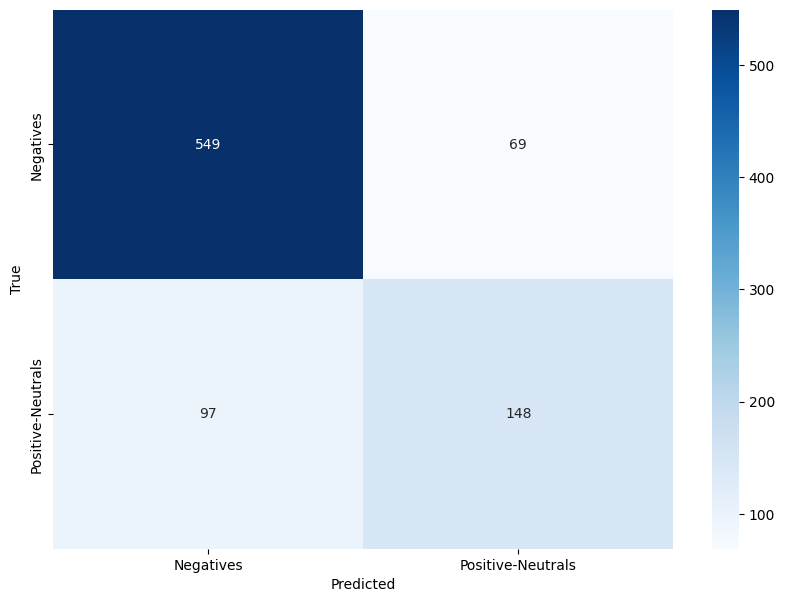

In [90]:
from sklearn.model_selection import GridSearchCV

def vectorize_text(text_series, model):
    """
    Converte uma série de textos em vetores utilizando o modelo Word2Vec.
    
    Args:
        text_series (pd.Series): Série de textos.
        model (KeyedVectors): Modelo Word2Vec treinado.
    
    Returns:
        np.ndarray: Matriz de vetores para os textos.
    """
    vectors = [np.mean([model[word] for word in text.split() if word in model] or [np.zeros(model.vector_size)], axis=0) for text in text_series]
    return np.array(vectors)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def logistic_regression_word2vec(df, model):
    """
    Avalia um modelo de regressão logística com Word2Vec usando o dataframe fornecido.
    
    Args:
        model (KeyedVectors): Modelo Word2Vec treinado.
        df (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo de regressão logística com Word2Vec para treino e teste.
    """
    X = df['0']
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Vetorizando os textos...")
    X_train_vectors = vectorize_text(X_train, model)
    X_test_vectors = vectorize_text(X_test, model)

    print("Definindo os parâmetros para o Grid Search...")
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  # 'liblinear' suporta tanto l1 quanto l2
    }

    print("Realizando o Grid Search com validação cruzada...")
    lr_model = LogisticRegression()
    grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_vectors, y_train)

    print(f'Melhores parâmetros: {grid_search.best_params_}')

    best_lr_model = grid_search.best_estimator_
    best_lr_model.fit(X_train_vectors, y_train)

    predictions = best_lr_model.predict(X_test_vectors)

    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    conf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(conf_matrix, labels=['Negatives', 'Positive-Neutrals'])

logistic_regression_word2vec(df_word2vec, model)


A célula acima usa **GridSearchCV** para explorar uma grade de hiperparâmetros (`C`, `penalty` e `solver`) para encontrar a melhor combinação que maximiza a acurácia do modelo. Após encontrar os melhores parâmetros, ela avalia o modelo com base em várias métricas, incluindo acurácia, f1-score, precisão e recall.

#### Testando Hiperparâmetros - RandomSearch

Vetorizando os textos...
Definindo os parâmetros para o Random Search...
Realizando o Random Search com validação cruzada...
Melhores parâmetros: {'C': 0.5622117123602399, 'penalty': 'l1', 'solver': 'liblinear'}
Acurácia do teste: 0.7937427578215527
f1_score: 0.7309171804932735
precision: 0.749496475327291
recall: 0.7192622680140017


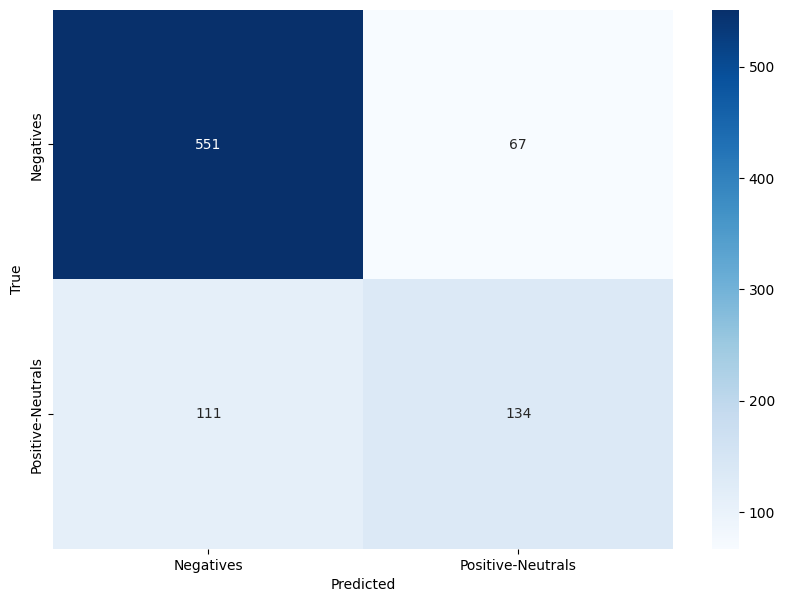

In [91]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

def vectorize_text(text_series, model):
    """
    Converte uma série de textos em vetores utilizando o modelo Word2Vec.
    
    Args:
        text_series (pd.Series): Série de textos.
        model (KeyedVectors): Modelo Word2Vec treinado.
    
    Returns:
        np.ndarray: Matriz de vetores para os textos.
    """
    vectors = [np.mean([model[word] for word in text.split() if word in model] or [np.zeros(model.vector_size)], axis=0) for text in text_series]
    return np.array(vectors)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def logistic_regression_word2vec(df, model):
    """
    Avalia um modelo de regressão logística com Word2Vec usando o dataframe fornecido.
    
    Args:
        model (KeyedVectors): Modelo Word2Vec treinado.
        df (DataFrame): DataFrame contendo a matriz de termos do documento (bag of words) com a coluna "sentiment" como alvo.
    
    Returns:
        None: A função imprime as métricas de avaliação do modelo de regressão logística com Word2Vec para treino e teste.
    """
    X = df['0']
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Vetorizando os textos...")
    X_train_vectors = vectorize_text(X_train, model)
    X_test_vectors = vectorize_text(X_test, model)

    print("Definindo os parâmetros para o Random Search...")
    param_dist = {
        'C': uniform(0.01, 100),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  # Removido 'saga' para evitar problemas de convergência
    }

    print("Realizando o Random Search com validação cruzada...")
    lr_model = LogisticRegression(max_iter=500)  # Aumentar max_iter para 500
    random_search = RandomizedSearchCV(estimator=lr_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train_vectors, y_train)

    print(f'Melhores parâmetros: {random_search.best_params_}')

    best_lr_model = random_search.best_estimator_
    best_lr_model.fit(X_train_vectors, y_train)

    predictions = best_lr_model.predict(X_test_vectors)

    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do teste: {accuracy}')

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'f1_score: {f1}')

    precision = precision_score(y_test, predictions, average='macro')
    print(f'precision: {precision}')

    recall = recall_score(y_test, predictions, average='macro')
    print(f'recall: {recall}')

    conf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(conf_matrix, labels=['Negatives', 'Positive-Neutrals'])

logistic_regression_word2vec(df_word2vec, model)


Esta célula usa **RandomizedSearchCV** para explorar uma distribuição de hiperparâmetros (`C`, `penalty`, `solver`) de forma aleatória, mas controlada, para encontrar a melhor combinação que maximiza a acurácia do modelo de Regressão Logística. O RandomizedSearchCV permite testar um número maior de combinações de hiperparâmetros em comparação ao GridSearchCV, em menos tempo. A célula também aumenta o número máximo de iterações (`max_iter`) para 500 para garantir a convergência do modelo.

Como podemos ver, nenhuma das técnicas utilizadas para a otimização de hiperparâmetros funcionou, já que os valores de acurácia de antes e depois da implementação do GridSearch e do RandomSearch continuam iguais.

## Métricas

### Comparação das Métricas de Desempenho entre Modelos Gaussian Naive Bayes e Embedding Layer

A célula a seguir contém o código necessário para comparar graficamente as métricas de desempenho dos dois modelos. Serão gerados gráficos de barras que mostram as métricas de acurácia, F1-Score, precisão e recall tanto para o treinamento quanto para o teste.


In [1]:
# Métricas para Gaussian Naive Bayes e Embedding Layer
metrics_nb = {
    'Acurácia': [0.7690, 0.7497],  # Treino, Teste
    'F1-Score': [0.7487, 0.7200],  # Treino, Teste
    'Precisão': [0.7418, 0.7126],  # Treino, Teste
    'Recall': [0.7737, 0.7489]     # Treino, Teste
}

metrics_embedding = {
    'Acurácia': [0.76, 0.76],  # Treino (mesmo do teste), Teste
    'F1-Score': [0.59, 0.71],  # Macro, Ponderada
    'Precisão': [0.72, 0.74],  # Macro, Ponderada
    'Recall': [0.59, 0.76]     # Macro, Ponderada
}

# Nomes das métricas
nomes_metricas = ['Acurácia', 'F1-Score', 'Precisão', 'Recall']

# Plotagem
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, metric in enumerate(nomes_metricas):
    axs[i].bar(np.arange(len(metrics_nb[metric])), metrics_nb[metric], width=0.4, label='Naive Bayes')
    axs[i].bar(np.arange(len(metrics_embedding[metric])) + 0.4, metrics_embedding[metric], width=0.4, label='Camada de Embedding')
    axs[i].set_xticks(np.arange(len(metrics_nb[metric])) + 0.2)
    axs[i].set_xticklabels(['Treino', 'Teste'])
    axs[i].set_title(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

### Embedding Layer

c:\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.7191 - loss: 0.5578 - val_accuracy: 0.7263 - val_loss: 0.4477
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.7422 - loss: 0.4347 - val_accuracy: 0.7393 - val_loss: 0.4363
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7515 - loss: 0.4068 - val_accuracy: 0.7561 - val_loss: 0.4346
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7707 - loss: 0.4088 - val_accuracy: 0.7728 - val_loss: 0.4265
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.7616 - loss: 0.4030 - val_accuracy: 0.7709 - val_loss: 0.4240
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.7840 - loss: 0.3999 - val_accuracy: 0.7691 - val_loss: 0.4268
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.7742 - loss: 0.3963 - val_accuracy: 0.7430 - val_loss: 0.4339
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7501 - loss: 0.4073 - val_accu

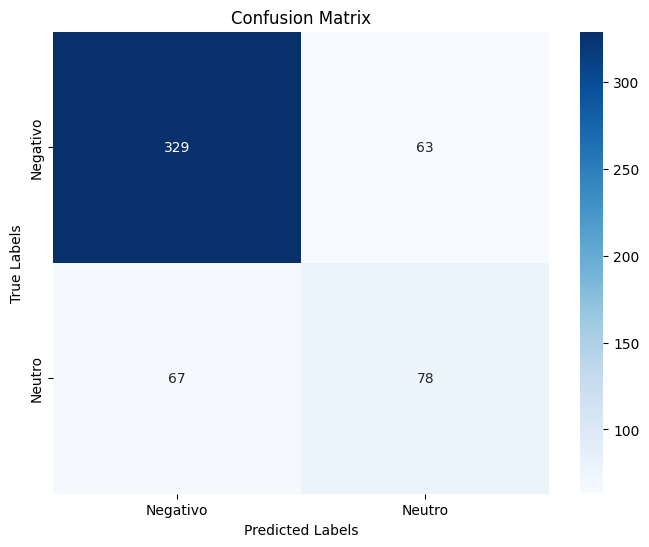

              precision    recall  f1-score   support

    Negativo       0.83      0.84      0.84       392
      Neutro       0.55      0.54      0.55       145

    accuracy                           0.76       537
   macro avg       0.69      0.69      0.69       537
weighted avg       0.76      0.76      0.76       537



In [93]:
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Função para carregar e preprocessar os dados
def load_and_preprocess_data():
    df = pd.read_csv("./data/classification-labeled.csv")
    df2 = pd.read_csv("./data/cleaned_data.csv")
    df = df.dropna(axis=0)
    df3 = pd.concat([df, df2], axis=1)

    comments = df3['0'].astype(str).apply(simple_preprocess)
    df3 = df3[df3['sentiment'].isin([-1, 0])]
    comments = df3['0'].astype(str).apply(simple_preprocess)

    return df3, comments

# Função para treinar o modelo Word2Vec
def train_word2vec(comments):
    word2vec_model = Word2Vec(sentences=comments, vector_size=100, window=5, min_count=1, workers=4)
    return word2vec_model

# Função para tokenizar e padronizar os textos
def tokenize_and_pad_texts(comments, max_words=10000, maxlen=100):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(comments)
    sequences = tokenizer.texts_to_sequences(comments)
    data = pad_sequences(sequences, maxlen=maxlen)
    
    return data, tokenizer

# Função para preparar a matriz de embedding
def prepare_embedding_matrix(tokenizer, word2vec_model, max_words=10000, embedding_dim=100):
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((max_words, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_words:
            try:
                embedding_vector = word2vec_model.wv[word]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
            except KeyError:
                continue
    
    return embedding_matrix

# Função para construir o modelo LSTM bidirecional
def build_model(embedding_matrix, max_words=10000, embedding_dim=100, input_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Função para treinar o modelo
def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return history

# Função para avaliar o modelo e plotar a matriz de confusão
def evaluate_model(model, x_val, y_val):
    y_pred = (model.predict(x_val) > 0.5).astype("int32")
    
    # Avaliação do modelo
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Acurácia do teste: {accuracy}')
    
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f'f1_score: {f1}')
    
    precision = precision_score(y_val, y_pred, average='macro')
    print(f'precision: {precision}')
    
    recall = recall_score(y_val, y_pred, average='macro')
    print(f'recall: {recall}')
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    plot_confusion_matrix(conf_matrix, labels=['Negativo', 'Neutro'])
    
    print(classification_report(y_val, y_pred, target_names=['Negativo', 'Neutro']))

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Main script
df3, comments = load_and_preprocess_data()
word2vec_model = train_word2vec(comments)
data, tokenizer = tokenize_and_pad_texts(comments)
labels = df3['sentiment'].astype(int).replace({-1: 0, 0: 1})
embedding_matrix = prepare_embedding_matrix(tokenizer, word2vec_model)

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
model = build_model(embedding_matrix)
history = train_model(model, x_train, y_train, x_val, y_val)

evaluate_model(model, x_val, y_val)
